In [1]:
import pandas as pd
import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

### Step 1: Read data

In [2]:
infile = '/g/data/xv83/dbi599/treasury/ffdi_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_19500101-20101231.nc'

In [3]:
ds = xr.open_dataset(infile)

In [5]:
ds

<xarray.Dataset> Size: 6GB
Dimensions:  (lat: 145, lon: 192, time: 55152)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 441kB 1950-01-01T12:00:00 ... 2100-12-31T1...
Data variables:
    FFDI     (lat, lon, time) float32 6GB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-ESM1-5 output prepared for CMIP6
    tracking_id:            hdl:21.14100/4553f1df-b8f3-4181-aca8-d617e2bee527
    variable_id:            FFDI
    variant_label:          r1i1p1f1
    version:                v20191115

In [6]:
location_name = 'Adelaide'
lat = -34.92
lon = 138.62
ds_point = ds.sel({'lat': lat, 'lon': lon}, method='nearest')

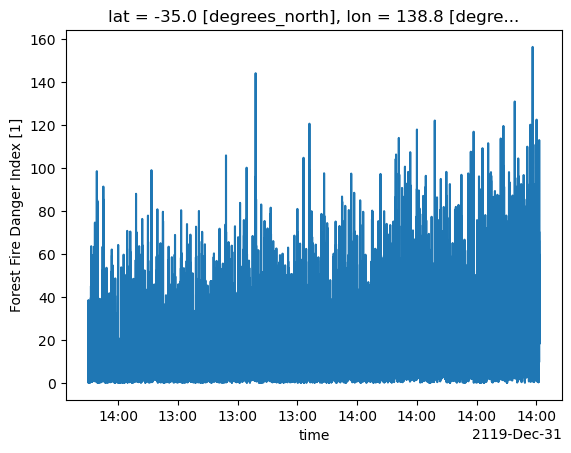

In [9]:
ds_point['FFDI'].plot()

In [10]:
ffdix = ds['FFDI'].resample({'time': 'YE'}).max('time', keep_attrs=True)

In [13]:
ffdix_point = ffdix.sel({'lat': lat, 'lon': lon}, method='nearest')

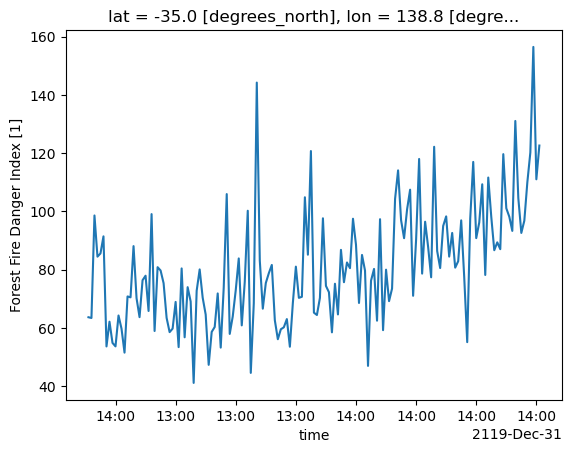

In [15]:
ffdix_point.plot()

### Step 2: Read shapefiles

In [16]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [17]:
states_gp = states_gp.drop(columns=['AREASQKM21', 'LOCI_URI21'])

In [18]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australian Capital Territory,ACT,"POLYGON ((149.06239 -35.1591, 149.09134 -35.14..."
8,Other Territories,OT,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748..."


We're working with a coarse resolution model with grid cells much larger than the ACT and other territories, so we'll leave those out:

In [19]:
states_gp = states_gp[:-2]

In [20]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."


In [21]:
aus_gp = states_gp.dissolve()
aus_gp['STE_NAME21'] = 'Australia'
aus_gp['ABBREV'] = 'AUS'

In [22]:
aus_gp

,geometry,STE_NAME21,ABBREV
0,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -...",Australia,AUS


In [23]:
states_gp = pd.concat([states_gp, aus_gp], ignore_index=True)

In [24]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australia,AUS,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -..."


We now need to turn our geopandas GeoDataFrame into a regionmask Regions object:

In [25]:
type(states_gp)

geopandas.geodataframe.GeoDataFrame

In [26]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states",
)

In [27]:
type(states_regions)

regionmask.core.regions.Regions

In [28]:
print(states_regions)

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory
7 AUS          Australia

[8 regions]


### Step 3: Create a mask

We can use the `mask_3D_frac_approx` method to calculate the fraction of each grid cell that overlaps with each shape:

In [29]:
frac = states_regions.mask_3D_frac_approx(ffdix)

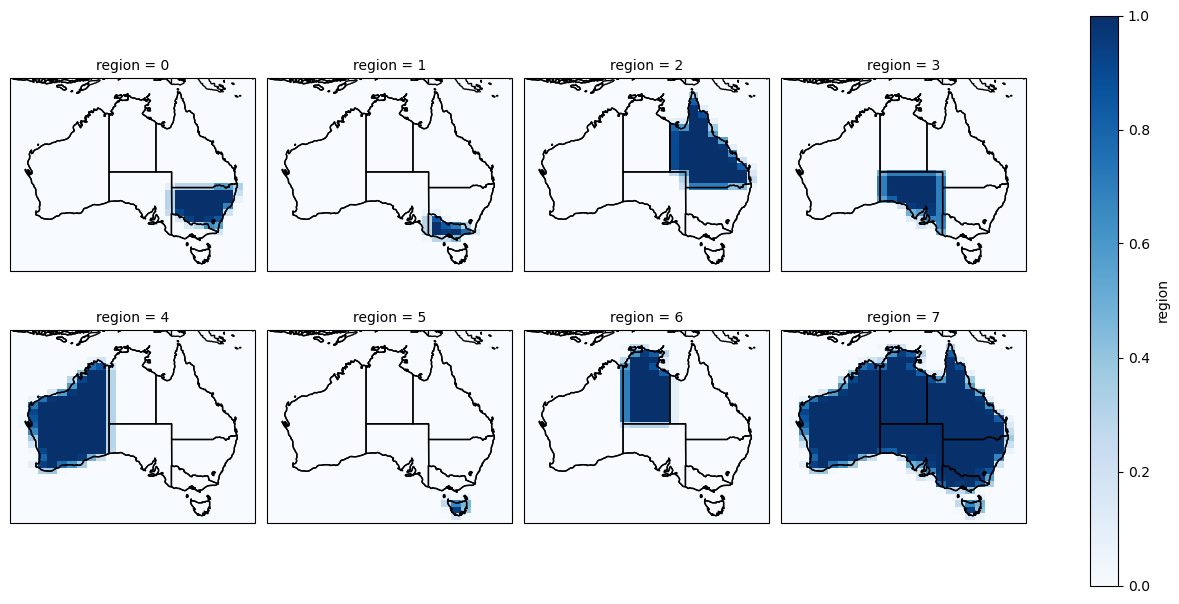

In [30]:
fg = frac.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
plt.show()

### Final step: Calculate a (weighted) regional mean

In [31]:
weights = np.cos(np.deg2rad(ffdix['lat']))

The most accurate spatial mean method is to multiply `weights` by the fractional overlap (`frac`) that we calculated earlier. That will ensure that an appropriate fractional value of the grid cells that are on the edge of the state/territory get included in the weighted average:

In [32]:
spatial_means = ffdix.weighted(frac * weights).mean(dim=("lat", "lon"))

In [33]:
print(spatial_means)

<xarray.DataArray 'FFDI' (time: 151, region: 8)> Size: 10kB
array([[ 56.93069837,  34.20588187,  56.78978076, ...,   8.39869389,
         68.39641037,  70.58999653],
       [ 65.29200539,  41.31755527,  73.88816695, ...,   7.69194505,
         98.10883505,  99.30966799],
       [ 80.83341362,  60.83073183,  78.27600051, ...,   7.14712286,
        106.91654472, 104.42254942],
       ...,
       [ 99.14517363,  77.30835905,  89.3311439 , ...,  13.57306973,
        115.68425326, 122.50944737],
       [ 99.65655989,  72.34633831,  90.55455116, ...,  13.26335221,
        115.28395353, 119.03453793],
       [104.58181849,  81.26765428,  89.17604917, ...,  10.88713552,
        119.25251379, 125.11114063]], shape=(151, 8))
Coordinates:
  * time     (time) datetime64[ns] 1kB 1950-12-31 1951-12-31 ... 2100-12-31
  * region   (region) int64 64B 0 1 2 3 4 5 6 7
    abbrevs  (region) <U3 96B 'NSW' 'VIC' 'QLD' 'SA' 'WA' 'TAS' 'NT' 'AUS'
    names    (region) <U18 576B 'New South Wales' 'Victoria' ..

In [36]:
df = spatial_means.to_pandas()
df.columns = spatial_means['abbrevs']
df.index = df.index.year
df = df.round(decimals=1)

In [37]:
df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1950,56.9,34.2,56.8,88.8,83.4,8.4,68.4,70.6
1951,65.3,41.3,73.9,137.6,120.8,7.7,98.1,99.3
1952,80.8,60.8,78.3,138.0,121.9,7.1,106.9,104.4
1953,78.3,60.3,68.0,112.8,104.3,9.4,78.2,87.8
1954,81.6,70.6,76.5,125.5,110.3,6.7,90.0,96.0
...,...,...,...,...,...,...,...,...
2096,102.1,62.3,95.7,167.3,138.3,11.3,125.2,123.0
2097,98.9,80.9,102.6,157.4,140.6,12.0,121.8,123.7
2098,99.1,77.3,89.3,164.2,146.9,13.6,115.7,122.5


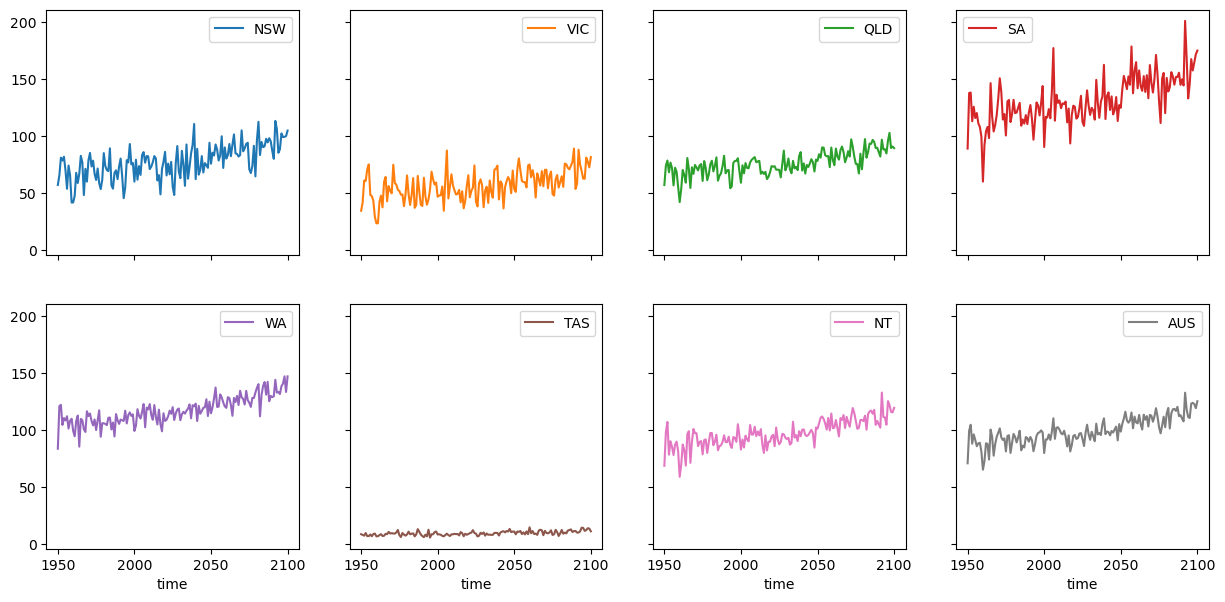

In [38]:
df.plot(
    figsize=[15, 7],
    subplots=True,
    layout=[2,4],
    sharey=True,
)
plt.show()

In [28]:
outfile = '/g/data/xv83/dbi599/treasury/ffdix_yr_ACCESS-ESM1-5_ssp370_r1i1p1f1_aus-states_1950-2100.csv'

In [29]:
df.to_csv(outfile)